# I] Import

In [12]:
import pandas, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

## functions & options


In [13]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [14]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

## Data download

In [15]:
%%time
# DL data ATG7 isoform expression and High low expression separation
path = output_file_directory + "/ATG7/dataframes_for_input/"
df_ATG7_iso1_LoHi_prim= pandas.read_csv(path+'df_ATG7_iso1_LoHi_prim.tsv', sep = "\t")
df_ATG7_iso2_LoHi_prim= pandas.read_csv(path+'df_ATG7_iso2_LoHi_prim.tsv', sep = "\t")

print(df_ATG7_iso2_LoHi_prim.shape)
df_ATG7_iso2_LoHi_prim.head(3)

(9130, 23)
Wall time: 87.8 ms


,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,TCGA-OR-A5J8-01,Primary Tumor,Adrenal Gland,Low_iso2,1.0,579.0,4.764,4.570,-1.639,-9.966,...,-1.495113e-07,4.816092,4.629437,0.400624,24.071456,98.670297,1.329703,-6.211145e-07,0.874174,0.011781
1,TCGA-OR-A5K5-01,Primary Tumor,Adrenal Gland,Low_iso2,1.0,498.0,4.751,4.216,-2.727,-4.608,...,4.000660e-02,4.803555,4.291540,0.201684,18.773186,98.987671,0.799224,2.131050e-01,0.690147,0.005572
2,TCGA-OR-A5K0-01,Primary Tumor,Adrenal Gland,Low_iso2,0.0,1029.0,4.074,3.784,-1.392,-3.171,...,1.100283e-01,4.157133,3.885007,0.464706,14.264252,96.564386,2.664256,7.713573e-01,0.817891,0.022566


# II] Log-Rank Test

In [19]:
# Log-Rank Test for Low Expression
## Define variables:
all_data = [["ATG7(1):", df_iso1_Low, df_iso1_High], 
            ["ATG7(2):", df_iso2_Low, df_iso2_High]]

for data in all_data:
    
    Time=data[1]['OS_time']
    Event=data[1]['OS']
    Time2=data[2]['OS_time']
    Event2=data[2]['OS']

    results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)
    print("Results for ", data[0])
    results.print_summary()
    print()

Results for  ATG7(1):


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.71 <0.005     16.00


Results for  ATG7(2):


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.29 <0.005      7.97

# III] CoxPHFitter

In [16]:
#CoxPHFitter
##Cox proportional hazard method is to notice, exp(coef) = HR
##how different factors in our dataset impact the event of interest

cph = CoxPHFitter()

df = df_ATG7_iso1_LoHi_prim.iloc[:,4:10]
cph.fit(df,'OS_time', 'OS')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 9130 total observations, 6461 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 9130
number of events observed = 2669
   partial log-likelihood = -22139.67
         time fit was run = 2022-02-28 22:02:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ATG7        0.35       1.42       0.06             0.24             0.47                 1.27                 1.59
ATG7_1     -0.32       0.73       0.04            -0.41            -0.23                 0.67                 0.80
ATG7_2      0.02       1.02       0.01            -0.00             0.03                 1.00                 1.04
ATG7_3     -0.04       0.96       0.01            -0.05            -0.03                 0.95                 0.97

              z      p   -log2(p)
covariate                        
ATG7       6.05 <0.005      29.37
ATG7_1    -7.06 <0.005      39.10
ATG7_2     1.67   0.09       3.41
ATG7_3    -7.68 <0.005      45.78
---
Concordance = 0.54
Partial AIC = 44287.33
log-likelihood ratio test = 92.90 on 4 df
-log2(p) of ll-ratio test = 61.45

# IV] Kaplan Meier

In [17]:
#split to have low and High in diffrent df
##iso1
df_iso1_Low = df_ATG7_iso1_LoHi_prim[df_ATG7_iso1_LoHi_prim['L/H'].str.startswith('Low_iso1')]
df_iso1_High = df_ATG7_iso1_LoHi_prim[df_ATG7_iso1_LoHi_prim['L/H'].str.startswith('High_iso1')]

##iso2
df_iso2_Low = df_ATG7_iso2_LoHi_prim[df_ATG7_iso2_LoHi_prim['L/H'].str.startswith('Low_iso2')]
df_iso2_High = df_ATG7_iso2_LoHi_prim[df_ATG7_iso2_LoHi_prim['L/H'].str.startswith('High_iso2')]

df_iso1_Low.head()

,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,TCGA-OR-A5LP-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,1857.0,4.058,2.501,2.1180,0.6145,...,1.530027e+00,4.142033,2.735474,2.416817,11.529721,49.088581,37.641131,13.270288,0.339817,0.260572
1,TCGA-OR-A5LO-01,Primary Tumor,Adrenal Gland,Low_iso1,1.0,2405.0,3.592,2.322,1.3680,0.4016,...,1.319972e+00,3.706827,2.584782,1.840010,8.899346,56.175466,28.992298,14.832237,0.414611,0.213982
2,TCGA-OU-A5PI-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,1171.0,3.522,2.725,0.3907,-1.3180,...,4.000906e-01,3.642304,2.928011,1.207911,8.320722,79.447458,15.744178,4.808363,0.575508,0.114049
3,TCGA-OR-A5LJ-01,Primary Tumor,Adrenal Gland,Low_iso1,1.0,1105.0,3.280,2.753,-3.3080,-4.2930,...,5.001269e-02,3.421231,2.952366,0.137464,6.890157,97.823231,1.450912,0.725857,0.693965,0.010293
4,TCGA-PK-A5H8-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,3623.0,3.257,2.761,0.3573,-9.9660,...,-1.495113e-07,3.400392,2.959336,1.189050,8.057686,84.114222,15.885780,-0.000002,0.709040,0.133909


Survival probability at 6000 days/ 16 years:
For ATG7(1) in low group: 0.25888051228223385
For ATG7(1) in high group: 0.35712759822305223

For ATG7(2) in low group: 0.33626311457572877
For ATG7(2) in high group: 0.28428890063701784



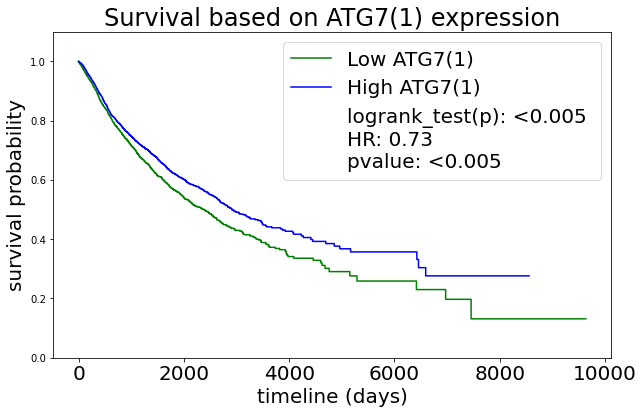

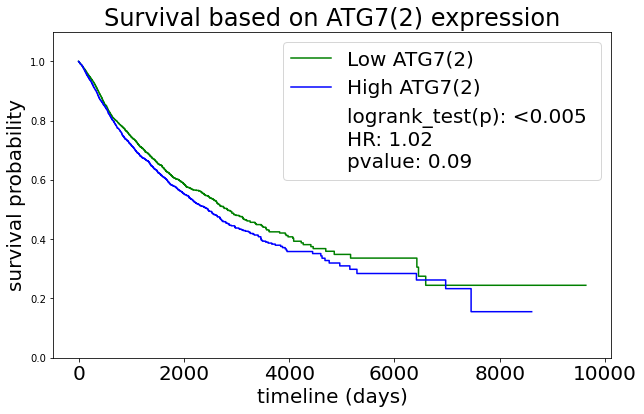

In [40]:
#KaplanMeier graph
all_data = [["ATG7(1)", df_iso1_Low, df_iso1_High, 'logrank_test(p): <0.005 \nHR: 0.73\npvalue: <0.005'], 
            ["ATG7(2)", df_iso2_Low, df_iso2_High, 'logrank_test(p): <0.005 \nHR: 1.02\npvalue: 0.09']]

#Create survival table 
kmf = KaplanMeierFitter() 
tables_kmf = []

print("Survival probability at 6000 days/ 16 years:")
for data in all_data:
    ##Low expression
    kmf.fit(data[1]['OS_time'], data[1]['OS'], label = "Low_KM_estim")
    print("For", data[0], "in low group:",  kmf.predict(6000))
    table_kmf_Low = kmf.survival_function_
    label1 = "Low "+ data[0]
    ##High expression
    kmf.fit(data[2]['OS_time'], data[2]['OS'], label = 'High_KM_estim')    
    print("For", data[0], "in high group:",  kmf.predict(6000))
    table_kmf_High = kmf.survival_function_
    label2 = "High "+ data[0]
    print()
    #save data
    tables_kmf.append(table_kmf_Low)
    tables_kmf.append(table_kmf_High)
    
    #Kaplan Meier Plot
    plt.figure(figsize=(10,6))
    seaborn.lineplot(data=table_kmf_Low, x='timeline', y='Low_KM_estim', color = "green", drawstyle='steps-post', label = label1)
    seaborn.lineplot(data=table_kmf_High, x='timeline', y='High_KM_estim', color = "blue", drawstyle='steps-post', label = label2)
    seaborn.regplot(x=[],y=[], marker=" ", label= data[3])

    plt.legend()
    plt.ylim(0,1.1) 
    plt.xlabel('timeline (days)')
    plt.ylabel('survival probability')
    
    title_text = "Survival based on "+data[0]+ " expression"
    plt.title(title_text)
    
    path = 'ATG7/figs_survival/all_tissue/'
    title_file = 'primary_kaplan_m_'+data[0]+'_alltissue.svg'
    plt.savefig(output_file_directory+path+title_file)